In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from tqdm import tqdm
import random
from API.ES_gt import evolutionary_strategy
import graph_tool.all as gt

In [2]:
# Read and filter original dataset
df = pd.read_json('/Users/francisco/Library/CloudStorage/GoogleDrive-fzanartua@gmail.com/My Drive/Socialz/COBOL/all_cobol_events_2011_2021.json', lines=True)
df = df[df['type'].isin(['ForkEvent','WatchEvent','PullRequestEvent','PushEvent'])].reset_index(drop=True)
df['actor'] = df['actor'].apply(lambda x: x.get('login'))
df['repo'] = df['repo'].apply(lambda x:x.get('name'))
df = df[['actor', 'repo', 'type']].rename(columns={'actor':'source', 'repo':'target'})

# Add user (u: ) repo (r: ) indicator for each node
df['source'] = df['source'].apply(lambda x: 'u: '+x)
df['target']  = df['target'].apply(lambda x: 'r: '+x)

# Read evolved dataset
edf = pd.read_csv('Data/Mutated_dataset.csv')

# Create es algorithm instances to compute user-user similarities:
es_df = evolutionary_strategy(df)
es_edf = evolutionary_strategy(edf)

# Add some helpul functions
combinations = es_edf.combinations

def map_combinations(edge_list):
    edge_list = edge_list.loc[edge_list['type'] != 'FollowEvent'].reset_index(drop=True)
    map_values = edge_list[['source','type']].groupby('source').apply(lambda x: combinations.get(tuple(sorted(x['type'].unique()))))
    return map_values


def complete_dataset(dataset):
    vertices = dataset[['source', 'target']].to_numpy()
    G = gt.Graph(directed=True)
    vertices = G.add_edge_list(vertices, hashed=True)
    ranks = gt.pagerank(G)
    d = [{'vertices':name, 'pagerank':ranks[vertex], 'degree':vertex.out_degree()+vertex.in_degree()} for vertex, name in zip(G.vertices(), vertices)]
    result = pd.DataFrame(d).set_index('vertices')
    result = result[result.index.str.startswith('u: ')]
    mapped_values = map_combinations(dataset)
    result = pd.concat([result, mapped_values], axis=1, ignore_index=False).rename(columns={0:'Values'})
    result = result.apply(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)), axis = 0)
    return result

def evaluation(dataset): return qmc.discrepancy(dataset, method='L2-star',workers=-1)


In [3]:
# Set seed for random samples:
seed = 1
np.random.seed(seed)

In [4]:
df_friends = es_df.complete_edgelist(df)
df_friends = df_friends[df_friends['type'] == 'FollowEvent']
df_friends_sum = len(df_friends)
summ = es_df.complete_edgelist(df).value_counts('type')
print('Summary of original dataset including FollowEvents (based on user\'s similarity:)')
print(summ)
print(f'Total events: {sum(summ):,}, total follow events: {df_friends_sum:,}, total non-FollowEvent: {sum(summ) - df_friends_sum:,}')

Summary of original dataset including FollowEvents (based on user's similarity:)
type
FollowEvent         6279126
PushEvent             18959
PullRequestEvent       7584
WatchEvent             6692
ForkEvent              4118
dtype: int64
Total events: 6,316,479, total follow events: 6,279,126, total non-FollowEvent: 37,353


In [5]:
edf_friends = es_edf.complete_edgelist(edf)
edf_friends = edf_friends[edf_friends['type'] == 'FollowEvent']
edf_friends_sum = len(edf_friends)
summ = es_edf.complete_edgelist(edf).value_counts('type')
print('Summary of evolved dataset including FollowEvents (based on user\'s similarity:)')
print(summ)
print(f'Total events: {sum(summ):,}, total follow events: {edf_friends_sum:,}, total non-FollowEvent: {sum(summ) - edf_friends_sum:,}')

Summary of evolved dataset including FollowEvents (based on user's similarity:)
type
FollowEvent         9613126
PushEvent             31639
PullRequestEvent      23352
WatchEvent            22899
ForkEvent             21067
dtype: int64
Total events: 9,712,083, total follow events: 9,613,126, total non-FollowEvent: 98,957


In [6]:
n = len(edf) - len(df)
print(f'Difference between non-FollowEvents {n:,} (Evolved - Original datasets)')

Difference between non-FollowEvents 61,604 (Evolved - Original datasets)


# Creating expanded datasets from original data.
## 1. Dummy version: takes n samples from the original dataset and duplicates them.
### Because of no new connections, (only duplicates) no new FollowEvents are created, only duplicated.

In [7]:
exp_dummy = pd.concat([df, df.sample(n=n, replace=True, random_state=seed), df_friends.sample(n=edf_friends_sum, replace=True, random_state=seed)], ignore_index=True)
exp_dummy

,source,target,type
0,u: blreay,r: blreay/test,PushEvent
1,u: CobViktor,r: janilisch/CobolGruppe,PushEvent
2,u: gigglegile,r: gigglegile/MavenSonarQube,PushEvent
3,u: krisds,r: krisds/koopa,PushEvent
4,u: tagadatsointsoin,r: tagadatsointsoin/project2,PullRequestEvent
...,...,...,...
9712078,u: ALEXIS-GARCIA,u: hxrox,FollowEvent
9712079,u: topgun82,u: andsel,FollowEvent
9712080,u: ddppddpp,u: gwythen,FollowEvent
9712081,u: Karla12,u: vaibhavjain30699,FollowEvent


In [8]:
summ = exp_dummy.value_counts('type')
dummy_friends = summ['FollowEvent']
print('Summary of expanded dataset, dummy version:')
print(summ)
print(f'Total events: {sum(summ):,}, total follow events: {dummy_friends:,}, total non-FollowEvent: {sum(summ) - dummy_friends:,}')
print(f'Star-discrepancy evaluation of expanded dataset, dummy version: {es_edf.objective(exp_dummy):.3f}')

Summary of expanded dataset, dummy version:
type
FollowEvent         9613126
PushEvent             50088
PullRequestEvent      20205
WatchEvent            17769
ForkEvent             10895
dtype: int64
Total events: 9,712,083, total follow events: 9,613,126, total non-FollowEvent: 98,957
Star-discrepancy evaluation of expanded dataset, dummy version: 0.560


In [9]:
#exp_dummy.to_csv('Data/expanded_dataset_dummy.csv', index=False)

## 2. Random version: creates n random new connections.
### First, create additional events, non-FollowEvents.

In [10]:
users = es_df.users
repos = es_df.repos
non_followevents = ['PushEvent','PullRequestEvent','WatchEvent','ForkEvent']

d = {'source':np.random.choice(users, n), 'target':np.random.choice(repos, n), 'type':np.random.choice(non_followevents, n)}

exp_random = pd.concat([df, pd.DataFrame(d)], ignore_index=True)
exp_random

,source,target,type
0,u: blreay,r: blreay/test,PushEvent
1,u: CobViktor,r: janilisch/CobolGruppe,PushEvent
2,u: gigglegile,r: gigglegile/MavenSonarQube,PushEvent
3,u: krisds,r: krisds/koopa,PushEvent
4,u: tagadatsointsoin,r: tagadatsointsoin/project2,PullRequestEvent
...,...,...,...
98952,u: 2DU,r: RemainSoftware/GITST,ForkEvent
98953,u: mrwillbarnz,r: dhineshaps/twopull,ForkEvent
98954,u: epireve,r: 12-tp9d/rvDialog,PushEvent
98955,u: irony,r: AkinJimoh/aj-soner,WatchEvent


### Now, create all possible FollowEvents and randomly sample the ones needed.

In [11]:
a = np.ones((len(users),len(users)), dtype=np.int8)
np.fill_diagonal(a, 0)
sources, targets = np.nonzero(a)
edge_list_users = pd.DataFrame({'source':list(map(users.__getitem__, sources)), 'target':list(map(users.__getitem__, targets))})

In [12]:
random_friends = edge_list_users.sample(edf_friends_sum, replace=True, random_state=seed)
random_friends['type'] = 'FollowEvent'
exp_random = pd.concat([exp_random, random_friends], ignore_index=True)

In [13]:
summ = exp_random.value_counts('type')
random_friends = summ['FollowEvent']
print('Summary of expanded dataset, random version:')
print(summ)
print(f'Total events: {sum(summ):,}, total follow events: {random_friends:,}, total non-FollowEvent: {sum(summ) - random_friends:,}')
print(f'Star-discrepancy evaluation of expanded dataset, dummy version: {evaluation(complete_dataset(exp_random)):.3f}')

Summary of expanded dataset, random version:
type
FollowEvent         9613126
PushEvent             34245
PullRequestEvent      22985
WatchEvent            22139
ForkEvent             19588
dtype: int64
Total events: 9,712,083, total follow events: 9,613,126, total non-FollowEvent: 98,957
Star-discrepancy evaluation of expanded dataset, dummy version: 0.128


In [34]:
# exp_random.to_csv('Data/expanded_dataset_random.csv', index=False)

In [14]:
original = es_df.complete_edgelist(df)
evolved = es_edf.complete_edgelist(edf)

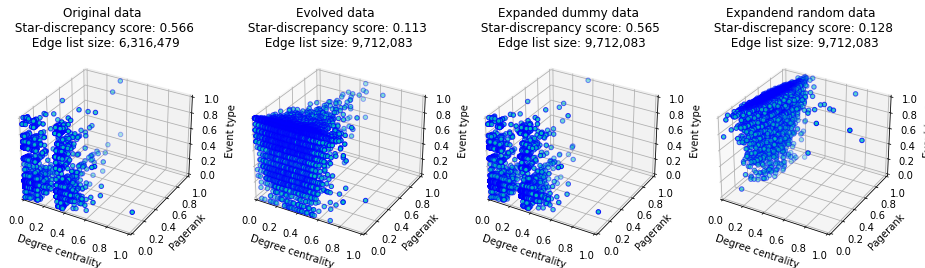

In [16]:
def draw_plot(ax, data, suptitle, size):
    
    ax = ax or plt.gca()
    
    ax.scatter3D(data['degree'], data['pagerank'], data['Values'], edgecolor='b', c='c')
    ax.set_xlabel('Degree centrality')
    ax.set_ylabel('Pagerank')
    ax.set_zlabel('Event type')
    ax.set_title(f'{suptitle} \n Star-discrepancy score: {evaluation(data):.3f} \n Edge list size: {size:,}')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    plt.close()
    
    return ax


fig, axes = plt.subplots(1,4, figsize=(16,8), subplot_kw=dict(projection="3d"))
#plt.subplots_adjust(wspace=0.5,hspace=0.5)
ax1, ax2, ax3, ax4 = axes.flatten()
ax1 = draw_plot(ax1, complete_dataset(original), 'Original data', len(original))
ax2 = draw_plot(ax2, complete_dataset(evolved), 'Evolved data',len(evolved))
ax3 = draw_plot(ax3, complete_dataset(exp_dummy), 'Expanded dummy data', len(exp_dummy))
ax4 = draw_plot(ax4, complete_dataset(exp_random), 'Expandend random data', len(exp_random))
plt.close()

fig
